In [64]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
df = pd.read_csv('publications_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 12043 non-null  int64  
 1   id                    12043 non-null  object 
 2   car_year              12043 non-null  int64  
 3   brand                 12043 non-null  object 
 4   brand_cod             12043 non-null  int64  
 5   model                 12043 non-null  object 
 6   model_cod             12043 non-null  int64  
 7   version               12043 non-null  object 
 8   engine                12043 non-null  float64
 9   engine_power          12043 non-null  float64
 10  doors                 12043 non-null  int64  
 11  km                    12043 non-null  int64  
 12  fuel_type             12043 non-null  object 
 13  fuel_type_cod         12043 non-null  int64  
 14  traction_control      12043 non-null  object 
 15  traction_control_co

## Pre-Procesamiento

### Tratamiento de outliers

In [66]:
#IMPORTACION DE LIBRERIAS
from sklearn.covariance import EllipticEnvelope

#INSTANCIA Y ENTRENAMIENTO DE MODELO PREDICTOR DE OUTLIERS
mcd = EllipticEnvelope(contamination=0.02)
predict = mcd.fit_predict(df.usd_price.values.reshape(-1,1))

#SE CONVIERTE RESULTADO A SERIE
predict = pd.Series(predict.flatten(), name='is_outlier')
predict = pd.concat([df.usd_price, predict], axis=1)
predict.head(3)

,usd_price,is_outlier
0,5200.0,1
1,6250.0,1
2,6000.0,1


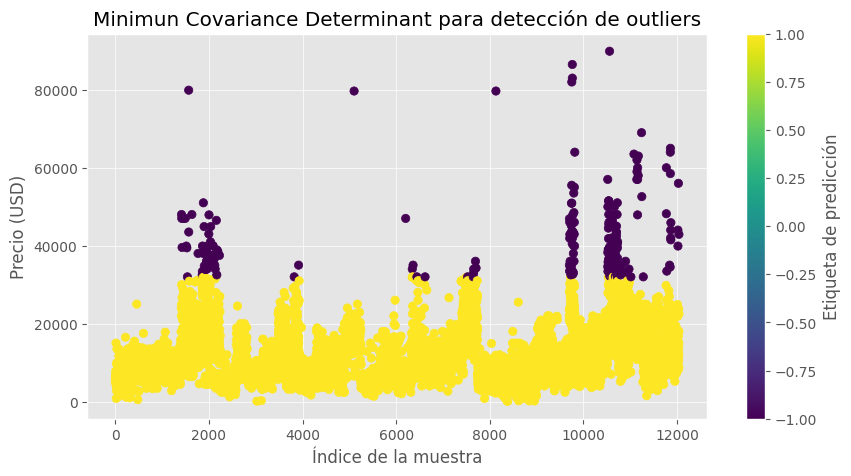

In [67]:
#GRAFICO DE OUTLIERS
mpl.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.scatter(predict.index, predict.usd_price, c=predict.is_outlier, cmap='viridis')
plt.xlabel('Índice de la muestra')
plt.ylabel('Precio (USD)')
plt.title('Minimun Covariance Determinant para detección de outliers')
plt.colorbar(label='Etiqueta de predicción')
plt.show()
mpl.style.use('bmh')

In [68]:
#INFORMACION DE LOS DATOS OBTENIDOS
outliers = df.loc[df.usd_price > 40000].shape[0]
print(f'La cantidad de valores mayores a 40000 USD es: {outliers}')
print(f'Porcentaje de outliers en ralacion al total de observaciones: {(outliers/df.shape[0])*100 :.2f}%')

La cantidad de valores mayores a 40000 USD es: 98
Porcentaje de outliers en ralacion al total de observaciones: 0.81%


In [69]:
df = df.loc[df.usd_price <= 40000].reset_index()

del predict, outliers, mcd

### Tratamiento de variables cualitativas

In [70]:
#CODIFICACION DE VARIABLE CUALITATIVA TRACTION_CONTROL
traction_control = pd.get_dummies(df.traction_control, prefix='tc_', dtype=int)
traction_control.head(3)

,tc__4x2,tc__4x4,tc__Delantera,tc__Integral,tc__Trasera
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0


In [71]:
#CODIFICACION DE VARIABLE CUALITATIVA FUEL_TYPE
fuel_type = pd.get_dummies(df.fuel_type, prefix='ft_', dtype=int)
fuel_type.head(3)

,ft__Diésel,ft__Eléctrico,ft__Híbrido/Diesel,ft__Híbrido/Nafta,ft__Nafta,ft__Nafta/GNC
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0


In [72]:
#CODIFICACION DE VARIABLE CUALITATIVA FUEL_TYPE
transmission = pd.get_dummies(df.transmission, prefix='t_', dtype=int)
transmission.head(3)

,t__Automática,t__Automática secuencial,t__Manual
0,0,0,1
1,0,0,1
2,0,0,1


In [73]:
#UNION DE VARIABLES
cualitative_vars = pd.concat([traction_control, fuel_type, transmission], axis=1)

#SE ELIMINAN VARIABLES
del traction_control, fuel_type, transmission

#VISTA DEL DF CON VARIABLES CODIFICADAS
cualitative_vars.head(3)

,tc__4x2,tc__4x4,tc__Delantera,tc__Integral,tc__Trasera,ft__Diésel,ft__Eléctrico,ft__Híbrido/Diesel,ft__Híbrido/Nafta,ft__Nafta,ft__Nafta/GNC,t__Automática,t__Automática secuencial,t__Manual
0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,0,0,0,1


## Modelado

### Feature Engineering

In [74]:
#NORMALIZACION DE VARIABLES
std_vars = StandardScaler().fit_transform(df[['car_year', 'km', 'engine_power']])
std_vars = pd.DataFrame(std_vars, columns=['car_year', 'km', 'engine_power'])
std_vars.head(3)

,car_year,km,engine_power
0,-1.203325,0.381122,-1.559872
1,-0.451473,0.518002,-1.010861
2,-0.827399,0.569778,-0.750804


In [75]:
#SELECCION DE VARIABLES PREDICTORAS
x = pd.concat([df.engine, std_vars, cualitative_vars], axis=1)

#SELECCION DE VARIABLE OBJETIVO
y = df.usd_price

#SEPARACION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=42)

### Etrenamiento, metricas y validacion de modelos

#### Regresion lineal

In [76]:
#INSTANCIA Y ENTRENAMIENTO DEL MODELO PREDICTIVO
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

In [77]:
#METRICAS DE REGRESION
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 2.497968139625854e+27
Root Mean Squared Error (RMSE): 49979677266123.42
R^2 Score: -6.634185499758557e+19


#### Random Forest Regressor

In [78]:
#IMPORTACION DE LIBRERIA
from sklearn.ensemble import RandomForestRegressor

#INSTANCIA Y ENTRENAMIENTO DEL MODELO PREDICTIVO
model = RandomForestRegressor()
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

In [79]:
#METRICAS DE REGRESION
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 5157466.97910081
Root Mean Squared Error (RMSE): 2271.0057197419846
R^2 Score: 0.8630263048376631


### Analisis de metricas, mejora de modelo y validacion cruzada

#### Tunning de hyperparametros

In [80]:
#IMPORTACION DE LIBRERIA
from sklearn.model_selection import GridSearchCV

# GRILLA DE HYPERPARAMETROS
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = GridSearchCV(estimator=RandomForestRegressor(),
                     param_grid=param_grid,
                     cv=3, n_jobs=-1)

model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

#SELECCION DE MEJORES HYPERPARAMETROS
hyperparam = model.best_params_

In [81]:
#METRICAS DE REGRESION
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 4854325.052306651
Root Mean Squared Error (RMSE): 2203.253288277735
R^2 Score: 0.8710772472944708


#### Validacion cruzada

In [82]:
#IMPORTACION DE LIBRERIA
from sklearn.model_selection import KFold

#INSTANCIA DEL MODELO DE VALIDACION CRUZADA
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#SPLITS PARA VALIDACION CRUZADA
train_test = list(kf.split(x,y))

#LISTA PARA GUARDAR LAS METRICAS DE LAS ITERACIONES
rmse_list = []
r2_list = []

#CICLO ITERATIVO
for k in range(kf.get_n_splits(x,y)):
    #Separacion en train y test
    train, test = train_test[k]
    X_train, y_train, X_test, y_test = x.iloc[train], y.iloc[train], x.iloc[test], y.iloc[test]
    
    #Instancia, entrenamiento y prediccion del modelo
    model = RandomForestRegressor(**hyperparam)
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)

    #Metricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    rmse_list.append(rmse)
    r2_list.append(r2)

    #Info de la iteracion
    print(f'Iteracion {k+1}:\n\t RMSE: {rmse:.4f}\n\t R^2: {r2:.4f}')

Iteracion 1:
	 RMSE: 2260.9695
	 R^2: 0.8649
Iteracion 2:
	 RMSE: 2151.6458
	 R^2: 0.8753
Iteracion 3:
	 RMSE: 2180.0985
	 R^2: 0.8774
Iteracion 4:
	 RMSE: 2196.7097
	 R^2: 0.8799
Iteracion 5:
	 RMSE: 2297.6686
	 R^2: 0.8648


In [83]:
print(f'Promedio RMSE: {np.array(rmse_list).mean() :.2f}')
print(f'Promedio R2: {np.array(r2_list).mean() :.2f}')

Promedio RMSE: 2217.42
Promedio R2: 0.87
